ADNI FILE: TADPOLE_D3(in).csv  
OBSERVATIONS: 896
FEATURES: 383

Mounted at /content/drive
Task 1.1a - Top 10 Missing Features:
                                              Count  Percent
ST81TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16     896    100.0
ST100SV_UCSFFSX_11_02_15_UCSFFSX51_08_01_16    896    100.0
ST87CV_UCSFFSX_11_02_15_UCSFFSX51_08_01_16     896    100.0
ST63SV_UCSFFSX_11_02_15_UCSFFSX51_08_01_16     896    100.0
ST122SV_UCSFFSX_11_02_15_UCSFFSX51_08_01_16    896    100.0
ST81SA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16     896    100.0
ST33SV_UCSFFSX_11_02_15_UCSFFSX51_08_01_16     896    100.0
ST22TS_UCSFFSX_11_02_15_UCSFFSX51_08_01_16     896    100.0
ST22TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16     896    100.0
ST81CV_UCSFFSX_11_02_15_UCSFFSX51_08_01_16     896    100.0


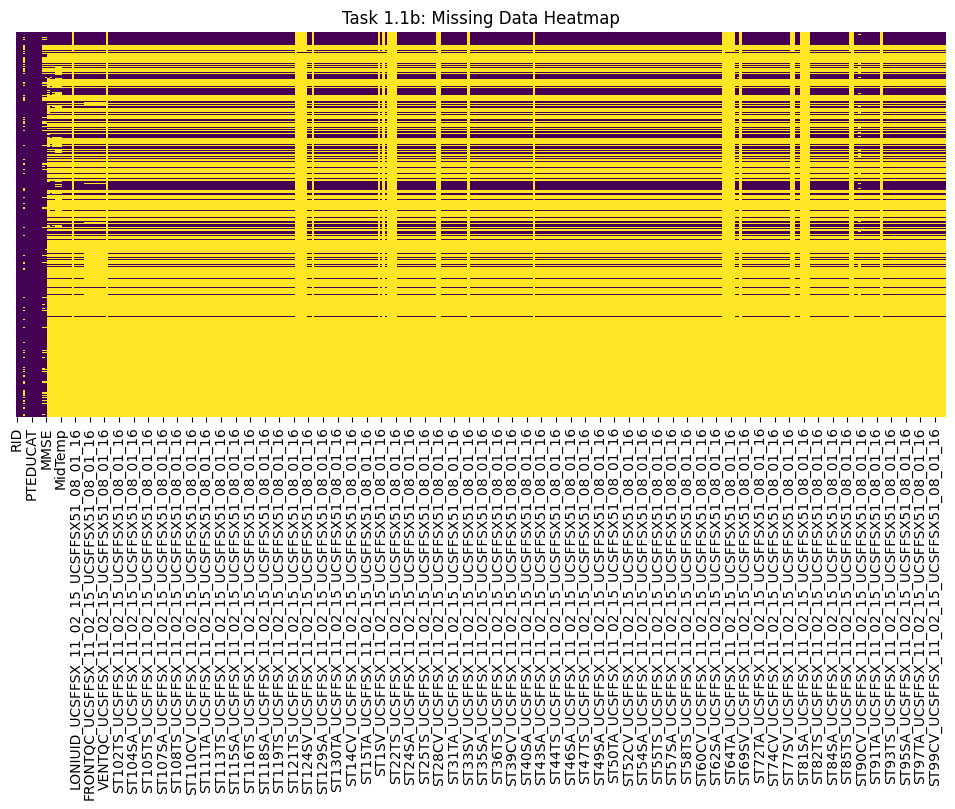

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.decomposition import PCA
import os
from google.colab import drive

drive.mount('/content/drive')

file_path = '/content/drive/MyDrive/Artificial_Intelligence/TADPOLE_D3(in).csv'
df = pd.read_csv(file_path)





# 1.1a Identify missing values
missing_counts = df.isnull().sum()
missing_percent = (missing_counts / len(df)) * 100
missing_report = pd.DataFrame({'Count': missing_counts, 'Percent': missing_percent}).sort_values(by='Percent', ascending=False)
print("Task 1.1a - Top 10 Missing Features:\n", missing_report.head(10))

# 1.1b Visualize missingness
plt.figure(figsize=(12, 5))
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')
plt.title('Task 1.1b: Missing Data Heatmap')
plt.show()

# 1.1c Action: Drop columns with >50% missing data to prevent bias
cols_to_drop = missing_report[missing_report['Percent'] > 50].index.tolist()
df_cleaned = df.drop(columns=cols_to_drop)

Task 1.2 & 1.3 - Incorrect and Unnecessary Data

In [6]:
# 1.2 Incorrect Data Detection & Action
# Example 1: Detect impossible values (Brain volumes should be > 0)
brain_cols = [col for col in df_cleaned.columns if col.startswith('ST')]

# Only proceed if there are 'ST' columns remaining after cleaning
if brain_cols:
    # Marking impossible <= 0 values as NaN to be handled by imputation
    df_cleaned.loc[df_cleaned[brain_cols[0]] <= 0, brain_cols[0]] = np.nan

    # Example 2: Statistical Outliers (Garbage detection)
    # We flag values more than 4 standard deviations from the mean
    if len(brain_cols) > 1:
        z_scores = np.abs((df_cleaned[brain_cols[1]] - df_cleaned[brain_cols[1]].mean()) / df_cleaned[brain_cols[1]].std())
        df_cleaned.loc[z_scores > 4, brain_cols[1]] = np.nan
    else:
        print("Warning: Only one 'ST' column found. Skipping statistical outlier detection for brain_cols[1].")
else:
    print("Warning: No 'ST' columns found in df_cleaned. Skipping brain volume specific data cleaning.")

# 1.3 Unnecessary Data
# Identifying redundant identifiers and zero-variance columns
unnecessary = ['RID', 'PTID', 'EXAMDATE', 'SITE']
constant_cols = [col for col in df_cleaned.columns if df_cleaned[col].nunique() <= 1]
df_cleaned.drop(columns=unnecessary + constant_cols, inplace=True, errors='ignore')

# Handle remaining NaNs with Median Imputation for Task 2/3
df_cleaned = df_cleaned.fillna(df_cleaned.median(numeric_only=True))
print(f"Task 1.2 & 1.3 Complete. Shape: {df_cleaned.shape}")

Task 1.2 & 1.3 Complete. Shape: (896, 10)


Task 2.1 - Feature Selection & Encoding

In [7]:
# 2.1 Encoding Categorical Features
# Identify categorical columns
cat_features = df_cleaned.select_dtypes(include=['object']).columns.tolist()
print(f"Categorical Features found: {cat_features}")

# If categories exist, we use One-Hot Encoding to avoid implying order (ordinal bias)
if cat_features:
    df_engineered = pd.get_dummies(df_cleaned, columns=cat_features, drop_first=True)
    print(f"Encoding applied. New dimensionality: {df_engineered.shape[1]} columns.")
else:
    df_engineered = df_cleaned.copy()

Categorical Features found: ['VISCODE', 'DX', 'PTGENDER', 'PTETHCAT', 'PTRACCAT', 'PTMARRY']
Encoding applied. New dimensionality: 43 columns.


Task 2.2 - Scaling Comparison (50 Samples)

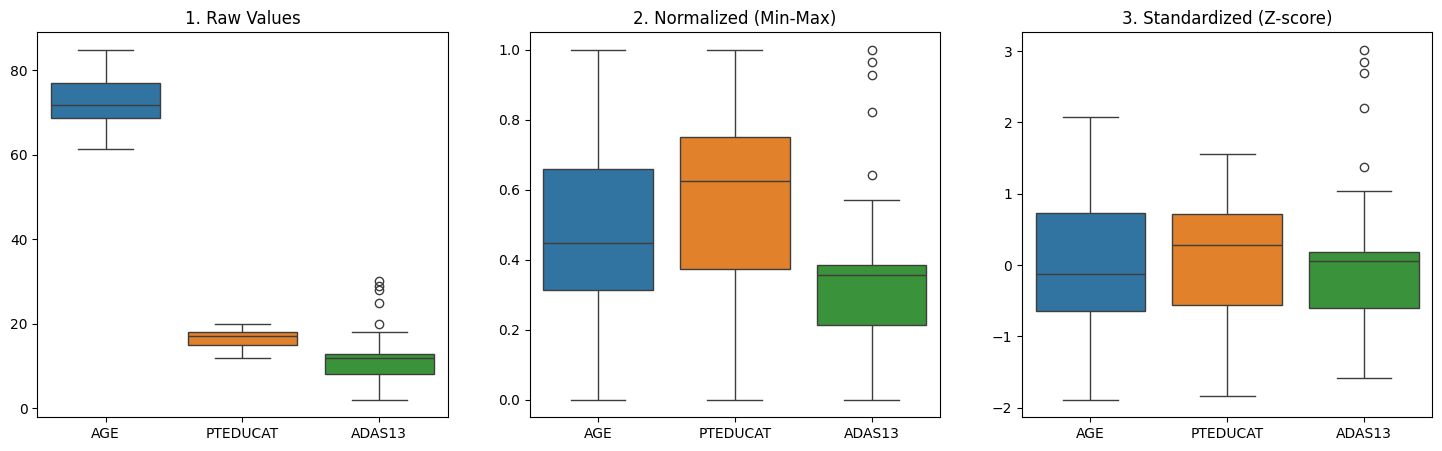

In [9]:
# Select 3 meaningful features for the scaling comparison

selected_3 = ['AGE', 'PTEDUCAT', 'ADAS13'] # Choose actual numerical columns present in df_engineered
sample_50 = df_engineered[selected_3].sample(50, random_state=42)

# Implementation of Scaling methods
norm_scaler = MinMaxScaler()
std_scaler = StandardScaler()

raw = sample_50.values
norm = norm_scaler.fit_transform(sample_50)
std = std_scaler.fit_transform(sample_50)

# 2.2 Visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.boxplot(data=sample_50, ax=axes[0]).set_title('1. Raw Values')
sns.boxplot(data=pd.DataFrame(norm, columns=selected_3), ax=axes[1]).set_title('2. Normalized (Min-Max)')
sns.boxplot(data=pd.DataFrame(std, columns=selected_3), ax=axes[2]).set_title('3. Standardized (Z-score)')
plt.show()

Dimensionality Reduction (PCA)

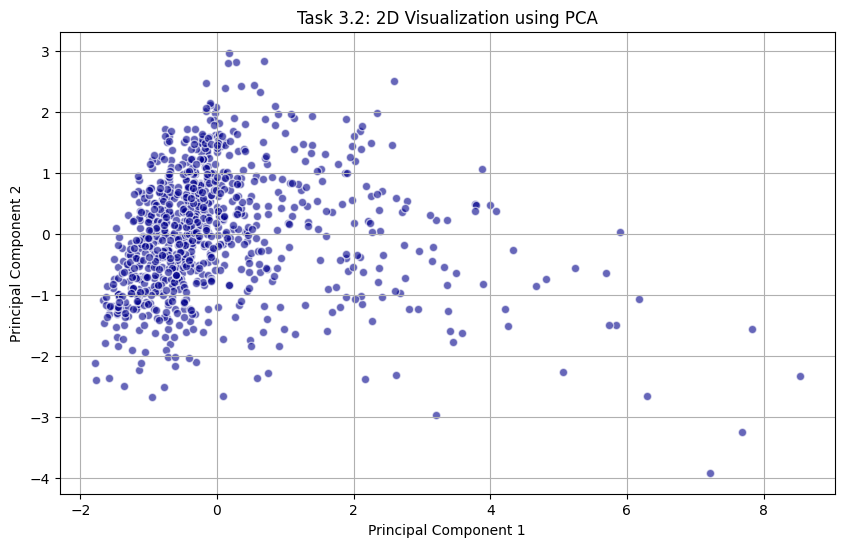

Variance explained by PC1 and PC2: 71.41%


In [10]:
# 3.2 Dimensionality Reduction (PCA)
# PCA is highly sensitive to scale, so we use the standardized version of the full cleaned set
numeric_final = df_engineered.select_dtypes(include=[np.number])
x_final = StandardScaler().fit_transform(numeric_final)

pca = PCA(n_components=2)
pca_output = pca.fit_transform(x_final)

# Visualization of the reduced space
plt.figure(figsize=(10, 6))
plt.scatter(pca_output[:, 0], pca_output[:, 1], alpha=0.6, c='darkblue', edgecolors='white')
plt.title('Task 3.2: 2D Visualization using PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

print(f"Variance explained by PC1 and PC2: {np.sum(pca.explained_variance_ratio_):.2%}")